# Agricultural Drought Risk Assessment
<br>

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=AGRICULTURE_DROUGHT_Risk_Assessment.ipynb) to launch the workflow on Binder!

---

In this workflow we will visualise the revenue losses deriving from the reduction in crops yield due to precipitation scarcity and  absence of irrigation. This assessment is particularly relevant for semi-arid regions (e.g., Mediterranean) which are increasingly prone to  prolonged drought periods making artificial irrigation unfeasible at times, as well as historically wet regions (e.g., Central and Northern Europe) that have not yet implemented artificial irrigation at large-scale but might experience a significant decline in precipitation rates with future climate change. 

## Risk Assessment methodology

The risk assessment methodology is described in detail in the [description](AGRICULTURE_Risk_workflow_description.md) file. In summary, data on  total crop production [ton] and revenue [EUR] is combined with the yield loss reduction calculated in the [hazard](AGRICULTURE_DROUGHT_Hazard.ipynb) workflow to derive a map of the revenue loss from absence of irrigation. Revenue loss is expressed here as the 'lost opportunity cost' of not using irrigation. The maps also shows the distribution of existing irrigation systems, which are used as a proxy of vulnerability to precipitation scarcity. The assessment is currently available for the same 15 crops available for the hazard assessment, but the selection can be expanded by modifying the [crop table](crop_table.csv). 

### Limitations
The main limitation of this approach is the fact that the crop production, aggregated value and irrigation distribution datasets refer to 2010 values and might not be accurately representative of current conditions. The user is invited to replace these datasets with more updated information whenever possible. The limitations of the yield loss calculation procedure are discussed in the [hazard](AGRICULTURE_DROUGHT_Hazard.ipynb) workflow.

## Load libraries
In this notebook we will use the following Python libraries:

In [1]:
import pandas as pd
import numpy as np
import rasterio
import pooch
import json
import urllib
import geopandas as gpd
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.basemap import Basemap
from pyDataverse.api import NativeApi, DataAccessApi
from pyDataverse.models import Dataverse
from mpl_toolkits.basemap import maskoceans
import re

:::{admonition}
:class: hint dropdown
- [numpy](https://numpy.org/doc/stable/index.html) - To make calculations and handle data in the form of arrays.
- [pandas](https://pandas.pydata.org/docs/index.html) - To store data in the form of DataFrames.
- [geopandas](https://geopandas.org/en/stable/index.html) - To read georeferenced files as DataFrames.
- [zipfile](https://docs.python.org/3/library/zipfile.html) - To extract files from zipped folders.
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download data from various repositories.
- [pyDataverse](https://pydataverse.readthedocs.io/en/latest/) - To download data from Harvard Dataverse. 
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format.
- [matplotlib](https://matplotlib.org/) and [Basemap](https://matplotlib.org/basemap/stable/)  - For plotting.
- [re](https://docs.python.org/3/library/re.html) - To rename files.


## Create the directory structure
First, we need to set up the directory structure to make the workflow work.
The next cell will create the directory called 'agriculture_workflow' in the same directory where this notebook is saved. A directory for data and one for results will also be created inside the main workflow directory to store the downloaded data and the final plots. 

In [2]:
workflow_dir = 'agriculture_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
    os.makedirs(workflow_dir)
    os.makedirs(data_dir)
    os.makedirs(results_dir)

## Define the studied area


The cells below allows to download the boundaries of any NUTS2 region in the EU as a GeoJson file given the region code (in this case ES51 for Catalunya). You can look up the NUTS2 code for all EU regions [here](https://ec.europa.eu/eurostat/documents/3859598/15193590/KS-GQ-22-010-EN-N.pdf) by simply searching the document for the region name. 

The coordinates of the selected regions are extracted and saved in an array. Finally, the geometry of the GeoJson file is saved as a shapefile to be used in the plotting phase.

In [3]:
region = ['ES51'] #Replace the code in [''] with that of your region 

In [4]:
#auxiliary function to load region GeoJson file.
def load_nuts_json(json_path):
    # dependencies: json, urllib, geopandas, 
    while True:
        uh = urllib.request.urlopen(json_path)
        data = uh.read()
        break  
    gdf = gpd.GeoDataFrame.from_features(json.loads(data)["features"])
    gdf['Location'] = gdf['CNTR_CODE'] 
    gdf = gdf.set_index('Location')
    #gdf.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
    return gdf

# load nuts2 spatial data
json_nuts_path = 'https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326_LEVL_2.geojson'
nuts = load_nuts_json(json_nuts_path)
nuts = nuts.loc[nuts['NUTS_ID'].isin(region)]

#extract coordinates
df=gpd.GeoSeries.get_coordinates(nuts)
coords_user=df.to_numpy()

#save geometry as shapefile
nuts_name=re.sub(r'[^a-zA-Z0-9]','',str(nuts.iloc[0,4]))
nuts_shape=nuts.geometry.explode(index_parts=True).to_file(f'{data_dir}/{nuts_name}.shp')

The code below creates the study area bounding box using the coordinates of the region GeoJson file. 

In some cases, it might be needed to expand the selected area through the 'scale' parameter to avoid the corners of the region being left out from the data extraction. The units of the 'scale' parameter are degrees, so setting scale=1 will increase the extraction area by approximately 100 km. A scale of 0-0.5 should be sufficient to fully cover most regions.  

:::{warning} The larger the scale parameter, the larger the extracted area, the longer the workflow will run for. Thus, the user is invited to have a first run of the workflow with scale=0.5, then increase it if not satisfied with the data coverage of the final map.

In [5]:
#Defining the region bounding box, scale parameter can be adjusted 
scale=0.5
bbox=[np.min(coords_user[:,0])-scale,np.min(coords_user[:,1])-scale,np.max(coords_user[:,0])+scale,np.max(coords_user[:,1])+scale]

## Import hazard data 

To run the risk assessment workflow you will first need to import data from the [hazard](AGRICULTURE_DROUGHT_Hazard.ipynb) workflow. If you have already run the hazard workflow you can ignore the cell below. If you have not, cancel the '#' in the cell below to activate the code and run it to start the hazard workflow creating the files needed for the risk assessment. This might take a few minutes.

::: {warning} The hazard assessment workflow uses Catalunya as a default region. If you want to run the risk workflow for a different region, change the selection in the [hazard](AGRICULTURE_DROUGHT_Hazard.ipynb) workflow first.

In [ ]:
#%run AGRICULTURE_DROUGHT_Hazard.ipynb

Run the cell below to load data from the hazard assessment and visualise them.

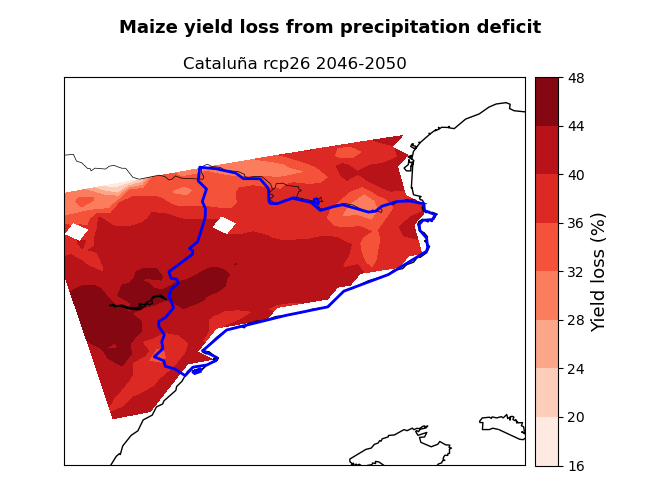

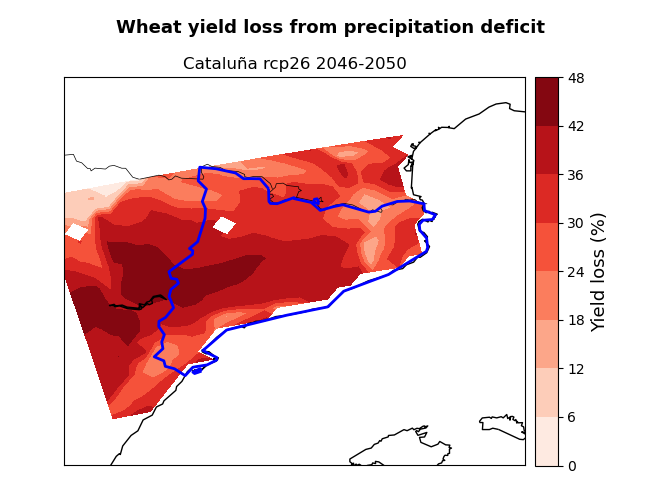

In [6]:
#load yield loss data from the .npy and .csv files produced by the hazard workflow
yield_loss_perc=np.load(f'{results_dir}/'+str(nuts.iloc[0,4])+'_yield_loss_NUMPY.npy')
hazard_df=pd.read_csv(f'{results_dir}/'+str(nuts.iloc[0,4])+'_yield_loss_SPREADSHEET.csv')


#visualise the yield loss maps produced by the hazard workflow

hazard_files = list(filter(lambda x: nuts.iloc[0,4] in x and 'yield_loss.png' in x, os.listdir(results_dir)))

for i in hazard_files:
    img = mpimg.imread(f'{results_dir}/{i}',format='png')
    fig=plt.figure()
    ax=fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()
    plt.imshow(img)
    plt.show()

## Download and extract Exposure data
### 1. Crops Production  

Next we will need data on crop production to calculate exposure. Crop production [ton] data for 2010 is retrieved from the [MapSPAM](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PRFF8V) repository on Harvard Dataverse. Data is available as global .tif rasters at 5 arc-min resolution for different combinations of human inputs and irrigation modes. In this assessment, we will use data for crops grown under 'high' human inputs and 'all' irrigation modes. 42 files are downloaded, one for each crop available on the MapSPAM repository. The step-by-step download procedure is explained within the code below.

In [ ]:
#specify path where the final zip file will be saved
spam_path=f'{data_dir}/spam_prod_geotiff.zip'

#create a folder in the data directory where all the SPAM files are extracted
if not os.path.exists(f'{data_dir}/spam_folder'):
    os.mkdir(f'{data_dir}/spam_folder')

#setting up the API to retrieve the SPAM dataset from Harvard Dataverse given the DOI. 
base_url = 'https://dataverse.harvard.edu/'
api = NativeApi(base_url)
data_api = DataAccessApi(base_url)
DOI='doi:10.7910/DVN/SWPENT' 
dataset = api.get_dataset(DOI)
files_list = dataset.json()['data']['latestVersion']['files']

#download the dataset for crops production given the ID
download_id='3985009'
response = data_api.get_datafile(download_id)
with open(spam_path, "wb") as f:
    f.write(response.content)


#extract the necessary SPAM files in the spam_folder,this selects the 'all' irrigation files only
with zipfile.ZipFile(spam_path, 'r') as zObject:
    file_list=zObject.namelist()
    selected_files = list(filter(lambda x: '_A.tif' in x, file_list))
    zObject.extractall(path=f'{data_dir}/spam_folder',members=selected_files)

:::{tip} You might be interested in other files in the SPAM directory other than the production ones used in this workflow. Run the cell below to print all the files in the SPAM repository and find the ID code needed to download them.

In [ ]:
files_list = dataset.json()['data']['latestVersion']['files']
for file in files_list:
    filename = file["dataFile"]["filename"]
    file_id = file["dataFile"]["id"]
    print("File name {}, id {}".format(filename, file_id))

To select the SPAM files for the crops you are interested in, you will have to correctly specify their name. Run the cell below to print the list of available crops. In the SPAM files, crops are identified by a 4-letter acronym in capital letters. For instance, Arabica Coffee is ACOF, cotton is COTT .

In [ ]:
selected_files

Now copy the acronym of the crops you want to study in the cell below and run it. In this example, we are interested in wheat and maize. **Remember** you can only get results for the 15 crops parameterised in the [crop table](crop_table.ipynb). 

In [7]:
spam_list=['WHEA','MAIZ']

The cell below extracts data from the SPAM files, first for the studied crops then for all available crops.


In [8]:
#get the extraction coordinates from the hazard dataframe
coords_11=np.stack((hazard_df['lon'].to_numpy(),hazard_df['lat'].to_numpy()),axis=1)

#extraxction of studied crops production 
df_spam=pd.DataFrame()
for i in os.listdir(f'{data_dir}/spam_folder'):
    for a in np.arange(len(spam_list)):
        if spam_list[a] in i:
            raster_path = os.path.join(f'{data_dir}/spam_folder', i)
            with rasterio.open(raster_path) as src:
                values = [x[0] for x in src.sample(coords_11)]
            # Create a new column for each raster
            df_spam[spam_list[a]] = values

crops_spam=df_spam.to_numpy(dtype='float64')
crops_spam[crops_spam<0]=np.nan
crops_spam=crops_spam.reshape(len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]),len(spam_list))

#extraction of all crops production
df_spam_all=pd.DataFrame()
for i in os.listdir(f'{data_dir}/spam_folder'):
    raster_path = os.path.join(f'{data_dir}/spam_folder', i)
    with rasterio.open(raster_path) as src:
        values = [x[0] for x in src.sample(coords_11)]

    # Create a new column for each raster
    df_spam_all[i] = values

df_spam_sum=df_spam_all.sum(axis=1)
spam_sum=df_spam_sum.to_numpy(dtype='float64')
spam_sum[spam_sum<0]=np.nan
spam_sum=spam_sum.reshape(len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]))


### 2. Crops Aggregated Value

The second exposure dataset we need is about crops aggregated value. Data is sourced from the FAO Global Agro-Ecological Zones (GAEZ) data [portal](https://gaez.fao.org/). Data is available as global .tif rasters at 11 km resolution showing the aggregated crops value in 2010 international dollars (GK$), having the same purchasing power of US dollars (USD).

In [ ]:
url = 'https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res06/V/2010/all_2010_val.tif'
filename = 'all_2010_val.tif'
pooch.retrieve(
    url=url,fname=filename,
    known_hash='ae8f7a3532912dbee24efbb83a5df0ca2685bc65c30fcdca6212fe72eba13d6e',
    path=data_dir)

The cell below extracts aggregated value data from the raster and stores them as an array.

In [9]:
#extract values
raster_path = f'{data_dir}/all_2010_val.tif'
val_gaez=pd.DataFrame()
with rasterio.open(raster_path) as src:
    values = [x[0] for x in src.sample (coords_11)]
val_gaez['val']=values
val_gaez=val_gaez.to_numpy(dtype='float64')
val_gaez[val_gaez<0]=np.nan
val_gaez=val_gaez.reshape(len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]))

## Download and extract Vulnerability data - Irrigation availability

Next we will need data on cropland full-irrigation availability to define vulnerability. This dataset is also sourced from GAEZ and is available at the same resolution as the aggregated value data. The dataset shows the percentage of cropland in each grid-cell equipped with full-irrigation systems.  

In [ ]:
url = 'https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/LR/wat/GLCSv11_12_5m.tif'
filename = 'GLCSv11_12_5m.tif'
pooch.retrieve(
    url=url,fname=filename,
    known_hash='798437a7c5bfa5887c5dd9eacb42b7388db9e4f3073b3c8d4cf4e5d6c9bcedb7',
    path=data_dir)

The cell below extracts irrigation availability data from the raster and stores them as an array.

In [10]:
#extract irrigation availability data
raster_path = f'{data_dir}/GLCSv11_12_5m.tif'
irr_share=pd.DataFrame()
with rasterio.open(raster_path) as src:
    values = [x[0] for x in src.sample(coords_11)]
irr_share['irr']=values
irr_share=irr_share.to_numpy(dtype='float64')
irr_share[irr_share==0]=0.1
irr_share=irr_share.reshape(len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]))

## Data processing

The first step in the risk assessment calculation entails defining the share of total crop production represented by the studied crops. 

In [11]:
#calculate the fraction of total production represented by the studied crops
crop_prod_fraction=np.zeros((len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]),len(spam_list)))
for i in np.arange(len(spam_list)):
    crop_prod_fraction[:,:,i]=crops_spam[:,:,i]/spam_sum

Next, we will need to determine the economic value per pixel of the studied crops. To do so, we will: 
1. Calculate the revenue per ton of the total crop production (USD/ton total)
2. Multiply the total revenue per ton for the studied crops fraction to get the value per ton for the studied crops (USD/ton studied) 
3. Multiply the studied crops revenue per ton for their production to get the revenue in each grid cell originating from the studied crops (USD/grid-cell)
4. Finally, multiply the revenue per grid-cell for the yield loss calculated in the hazard workflow we will get the reduced revenue due to absence of irrigation (USD/grid-cell)

In [12]:
#create empty arrays to store info
rev_per_ton_tot=np.zeros((len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]),len(spam_list)))
rev_per_ton_crop=np.zeros((len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]),len(spam_list)))
rev_per_pixel_crop=np.zeros((len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]),len(spam_list)))
new_rev_per_pixel_crop=np.zeros((len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]),len(spam_list)))


for a in np.arange(len(spam_list)):
    #step 1: total revenue per ton
    rev_per_ton_tot=val_gaez/spam_sum
    #step 2: studied crops revenue per ton
    rev_per_ton_crop[:,:,a]=rev_per_ton_tot*crop_prod_fraction[:,:,a]
    #step 3: studied crops revenue per grid-cell
    rev_per_pixel_crop[:,:,a]=rev_per_ton_crop[:,:,a]*crops_spam[:,:,a]
    #step 4: studied crops revenue per grid-cell without irrigation
    new_rev_per_pixel_crop[:,:,a]=rev_per_ton_crop[:,:,a]*crops_spam[:,:,a]*yield_loss_perc[:,:,a]/100


#calculate the revenue loss as the difference between step 3 and step 4    
revenue_loss=rev_per_pixel_crop-new_rev_per_pixel_crop

#convert from USD to EUR at 2010 exchange rate
reveune_loss_euro=revenue_loss/1.3    

## Plotting the results

The cell below allows to plot the revenue loss results for the studied region. The red shading shows the revenue loss per grid-cell for the studied crops deriving from the absence of irrigation. The hatching shows different levels of irrigation infrastructure availability within the region, highlighting areas of different vulnerability.

The resulting plot states the crop, RCP scenario and reference period used in the assessment. The plotting procedure steps are described within the cell.

:::{tip} Use the 'zoom' paramerter to set how much you would like the final plot to be zoomed-out from the region boundaries (0=no zoom out,1=100 km). Here a zoom of 0.5 degrees (50 km) is used.

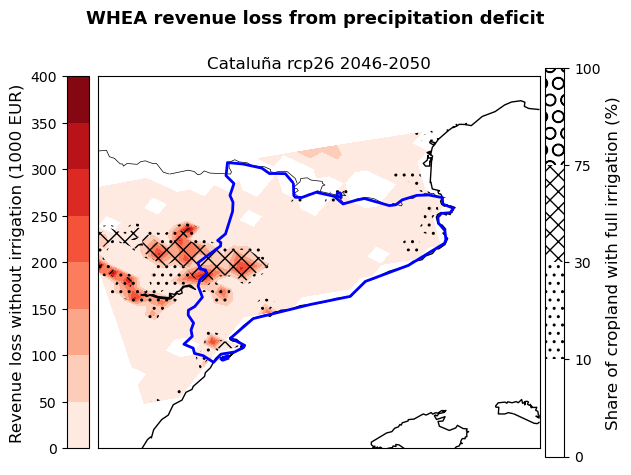

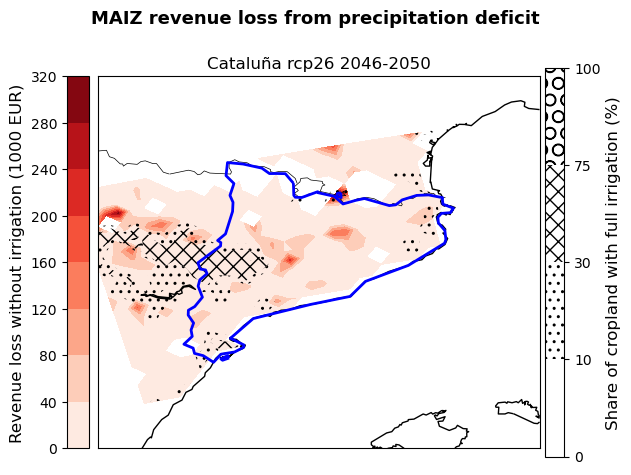

In [13]:
rcp=hazard_df['rcp'][0] #identify the climate projection
ystart=hazard_df['start_year'][0] #identify the projection start year
yend=hazard_df['end_year'][0] #identify the projection end year

#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=hazard_df['lon'].to_numpy().reshape(len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]))
lat_plot=hazard_df['lat'][:].to_numpy().reshape(len(yield_loss_perc[:,0,0]),len(yield_loss_perc[0,:,0]))

#define the irrigation vulnerability levels
irr_levels=np.array([0,10,30,75,100])
irr_share_plot=maskoceans(lon_plot,lat_plot,irr_share,resolution='h')

for a in np.arange(len(spam_list)):
    #create the basemap around the region boundaries
    basemap =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])
    basemap.drawcoastlines()
    basemap.drawcountries()
    
    #plot the revenue loss
    revenue_map=basemap.contourf(lon_plot,lat_plot,revenue_loss[:,:,a],cmap='Reds',zorder=1)
    revenue_cbar=basemap.colorbar(revenue_map,location='left',ticklocation='left')
    revenue_cbar.set_label('Revenue loss without irrigation (1000 EUR)',fontsize=12)
   
    #plot the irrigation availability
    irr_map=basemap.contourf(lon_plot,lat_plot,irr_share_plot,colors='none',hatches=['','..','xx','O'],zorder=1,levels=irr_levels)
    irr_cbar=plt.colorbar(irr_map,fraction=0.04,pad=0.011)
    irr_cbar.set_label('Share of cropland with full irrigation (%)',fontsize=12)
    
    #draw region boundaries from shapefile
    basemap.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) 
    
    plt.suptitle(spam_list[a]+' revenue loss from precipitation deficit',fontsize=13,fontweight='bold') #title
    plt.title(str(nuts.iloc[0,4])+' '+rcp+' '+str(ystart)+'-'+str(yend)) #subtitle
    plt.tight_layout()
    
    #save plots in results directory
    plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_'+str(spam_list[a])+'_revenue_loss_EUR.png') 
    plt.show()

The figures produced show the potential revenue losses from irrigation deficit in the studied region for the selected crops (here maize and wheat), emission scenario (here RCP2.6) and period (here 2046-2050). Losses are expressed by the red shading and represent the 'lost opportunity cost' in thousands EUR if crops are grown under non-irrigated conditions. The hatches show the share of cropland in each grid-point with full-irrigation systems already implemented in 2010 and serves as an indicator of vulnerability to the absence of rainfall. 
<br>

These maps can be used by demonstrators to understand which areas of their region are expected to suffer the greatest losses, as well as which crops will be the most impacted by the absence of irrigation. This allows them to target adaptation efforts, such as the improvement of the current irrigation network, in the most affected and vulnerable areas favouring a cost-effective use of resources. At the same time, the map provides a snap-shot of a potential future growing season that can be used to guide cropland expansion towards areas and products less affected by water stress.


## Conclusions

Now that you were able to calculate damage maps based on yield loss maps and view the results, you can consider the following questions:

- How accurate do you think this result is for your local context? 
- What additional information are you missing that could make this assessment more accurate?
- What can you already learn from these maps of potential yield and revenue losses?

:::{important}
In this risk workflow we learned:

- how to access and use global datasets on crop production and irrigation availability.
- how to combine data on potential yield losses to the current crop production to estimate future potential revenue losses.
- how to use maps of irrigation distribution as a proxy for water-stress vulnerability.

## Contributors

Euro-Mediterranean Center on Climate Change (CMCC), Italy.

Author of the workflow: Andrea Rivosecchi